# Customer Churn Prediction Using K-means Clustering and (ANN)

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from tensorflow.keras.optimizers import Adam 
from sklearn.ensemble import RandomForestClassifier

In [12]:
# Load the dataset
dataset = pd.read_csv("Telco-Customer-Churn.csv")
dataset.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
153,9073-ZZIAY,Male,0,Yes,Yes,62,Yes,No,DSL,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Electronic check,86.10,5215.25,No
6808,1116-DXXDF,Male,0,No,No,39,Yes,No,Fiber optic,Yes,...,Yes,No,Yes,Yes,Two year,Yes,Electronic check,100.45,3801.7,No
4332,4194-FJARJ,Female,0,Yes,Yes,54,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,No,Bank transfer (automatic),60.00,3273.95,No
6460,8761-NSOBC,Male,0,No,No,44,Yes,No,Fiber optic,No,...,No,Yes,Yes,Yes,Month-to-month,No,Electronic check,100.55,4398.15,Yes
3910,8938-UMKPI,Female,0,No,No,47,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,106.40,5127.95,Yes
6103,8573-CGOCC,Male,0,No,No,16,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),19.75,294.9,No
2759,1194-SPVSP,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),19.65,19.65,No
4350,1518-OMDIK,Male,0,Yes,No,33,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Credit card (automatic),44.55,1462.6,No
3000,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55,Yes
3700,5616-PRTNT,Male,0,No,Yes,20,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,19.40,374.5,Yes


In [13]:
# Data Cleaning
dataset.drop('customerID', axis='columns', inplace=True)
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')
dataset = dataset.dropna()

In [14]:
# Check the columns in the dataset
print("Columns in dataset:", dataset.columns)

# Data Cleaning
# Drop the 'customerID' column if it exists
if 'customerID' in dataset.columns:
    dataset.drop('customerID', axis='columns', inplace=True)

Columns in dataset: Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [15]:
# Convert 'TotalCharges' to numeric, forcing errors to NaN
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')

# Drop rows where 'TotalCharges' is NaN after conversion
dataset = dataset.dropna(subset=['TotalCharges'])

# Encode categorical variables
label_encoders = {}
for column in dataset.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset[column] = le.fit_transform(dataset[column])
    label_encoders[column] = le

In [16]:
# Feature Engineering: Create new feature 'TenureByMonthlyCharges'
dataset['TenureByMonthlyCharges'] = dataset['tenure'] * dataset['MonthlyCharges']

/home/rnamala/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


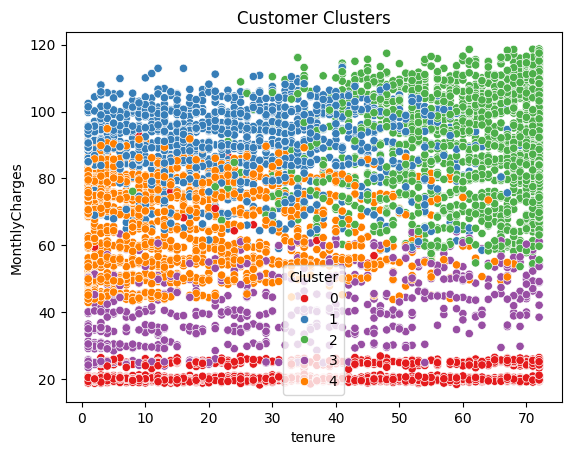

In [17]:
# Clustering with K-Means
features_for_clustering = dataset.drop(columns=['Churn'])

# Standardize the features for clustering
scaler_clustering = StandardScaler()
features_for_clustering_scaled = scaler_clustering.fit_transform(features_for_clustering)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=0) 
dataset['Cluster'] = kmeans.fit_predict(features_for_clustering_scaled)

# Visualize clusters
sns.scatterplot(x=dataset['tenure'], y=dataset['MonthlyCharges'], hue=dataset['Cluster'], palette='Set1')
plt.title('Customer Clusters')
plt.show()


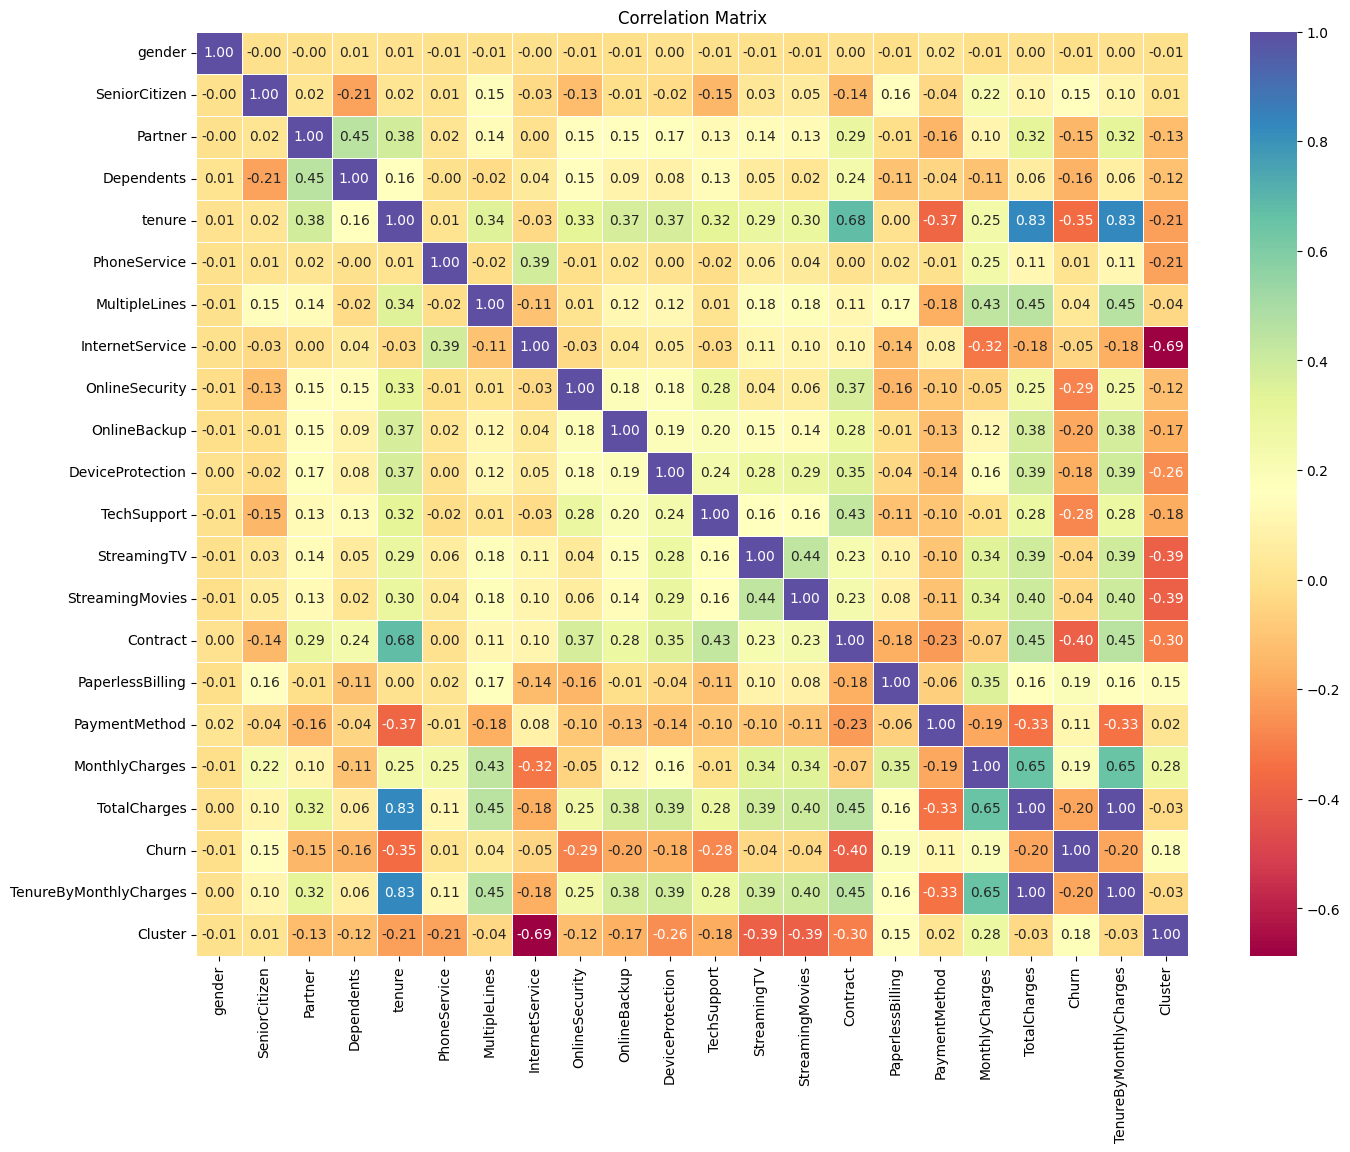

In [18]:
# Compute the correlation matrix
correlation_matrix = dataset.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='Spectral', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

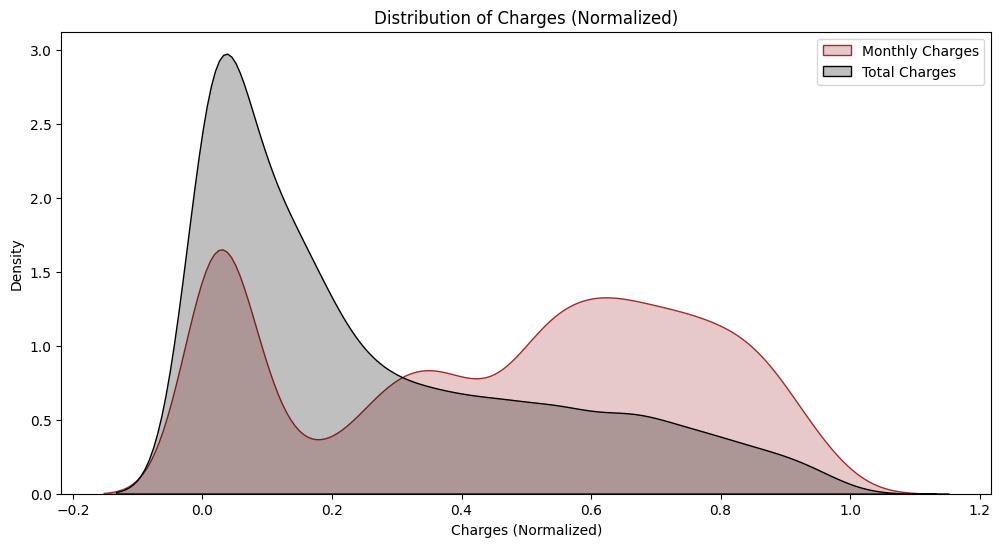

In [19]:
# This graph allows for comparison of the distribution patterns between monthly and total charges, 
#highlighting differences in their typical values and variability.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dataset[['MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(dataset[['MonthlyCharges', 'TotalCharges']])

# Distribution of MonthlyCharges and TotalCharges
plt.figure(figsize=(12, 6))
sns.kdeplot(dataset['MonthlyCharges'], fill=True, label='Monthly Charges', color='brown')
sns.kdeplot(dataset['TotalCharges'], fill=True, label='Total Charges', color='black')
plt.title('Distribution of Charges (Normalized)')
plt.xlabel('Charges (Normalized)')
plt.ylabel('Density')
plt.legend()
plt.show()


In [20]:
# Split the dataset into features and target variable
X = dataset.drop(columns='Churn')
y = dataset['Churn']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Model Selection and Evaluation
# Train and evaluate multiple models to select the best one

# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(random_state=0)
clf_lr.fit(X_train_scaled, y_train)
y_pred_lr = clf_lr.predict(X_test_scaled)

# Evaluate the Logistic Regression model
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)

results = pd.DataFrame([['Logistic Regression', acc_lr, f1_lr, prec_lr, rec_lr]],
                       columns=['Model', 'Accuracy', 'F1', 'Precision', 'Recall'])

In [22]:
# XGBoost with Hyperparameter Tuning using Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=XGBClassifier(random_state=0), param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_

Best Parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
XGBoost Confusion Matrix:
[[941  97]
 [175 194]]


/tmp/ipykernel_2548687/1884932954.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


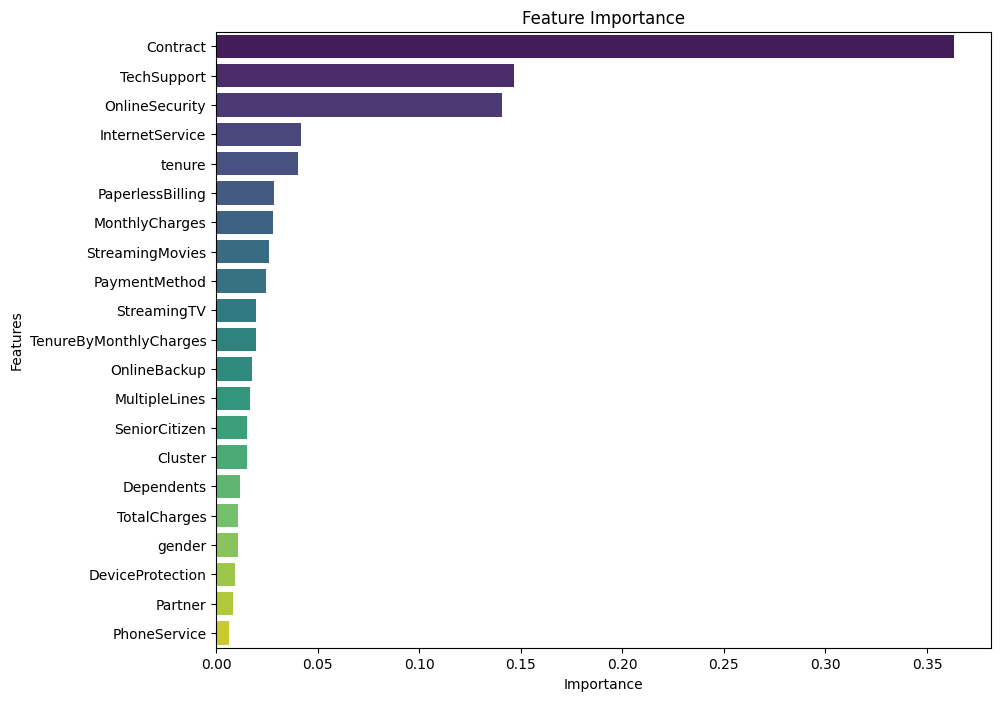

In [23]:
# Train a new XGBoost model with the best parameters
clf_xgb = XGBClassifier(random_state=0, **best_params)
clf_xgb.fit(X_train_scaled, y_train)
y_pred_xgb = clf_xgb.predict(X_test_scaled)

# Evaluate the XGBoost model
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)

XGB_results = pd.DataFrame([['XGBoost Classifier', acc_xgb, f1_xgb, prec_xgb, rec_xgb]],
                          columns=['Model', 'Accuracy', 'F1', 'Precision', 'Recall'])

results = pd.concat([results, XGB_results], ignore_index=True)

# Print evaluation metrics for XGBoost
print("Best Parameters for XGBoost:", best_params)
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# Get feature importances and corresponding feature names
feature_importances = clf_xgb.feature_importances_
feature_names = X.columns

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort features by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()


In [24]:
# Cross-validation for XGBoost
cv_scores = cross_val_score(clf_xgb, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores for XGBoost:", cv_scores)
print("Average CV Score for XGBoost:", np.mean(cv_scores))


Cross-Validation Scores for XGBoost: [0.81066667 0.79644444 0.80088889 0.808      0.81244444]
Average CV Score for XGBoost: 0.8056888888888889


In [25]:
# Build and compile the ANN model
model = Sequential([
    Dense(16, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model with the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the ANN model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


/home/rnamala/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5770 - loss: 0.6731 - val_accuracy: 0.7422 - val_loss: 0.5055
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7407 - loss: 0.5048 - val_accuracy: 0.7556 - val_loss: 0.4763
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7499 - loss: 0.4773 - val_accuracy: 0.7600 - val_loss: 0.4662
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7591 - loss: 0.4603 - val_accuracy: 0.7760 - val_loss: 0.4609
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7640 - loss: 0.4716 - val_accuracy: 0.7804 - val_loss: 0.4578
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7610 - loss: 0.4618 - val_accuracy: 0.7778 - val_loss: 0.4538
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7675 - loss: 0.4490 - val_accuracy: 0.7858 - val_loss: 0.4505
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7825 - loss: 0.4537 - val_accuracy: 0.7858 - val_

In [26]:
# Evaluate the ANN model
y_pred_proba = model.predict(X_test_scaled)
y_pred_ann = (y_pred_proba > 0.5).astype(int)

# Print classification report for ANN
print(classification_report(y_test, y_pred_ann))

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1038
           1       0.65      0.53      0.58       369

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.80      0.80      1407



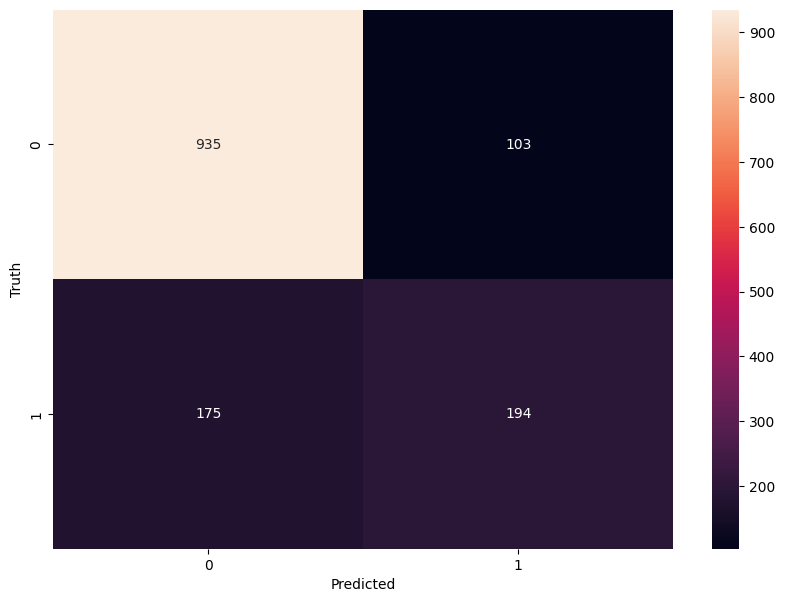

In [27]:
# Plot confusion matrix for ANN
cm = confusion_matrix(y_test, y_pred_ann)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

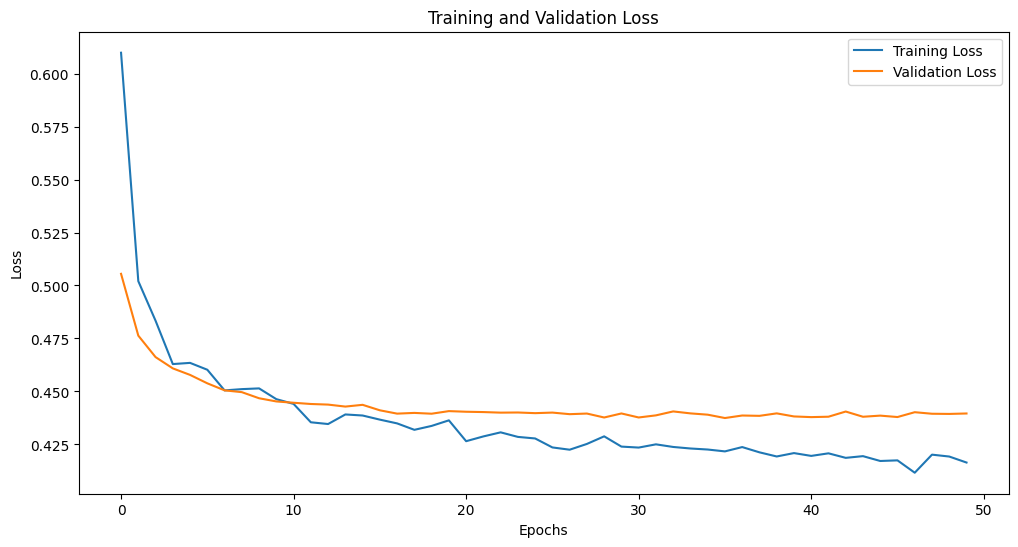

In [28]:
# Plot training and validation loss for ANN
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

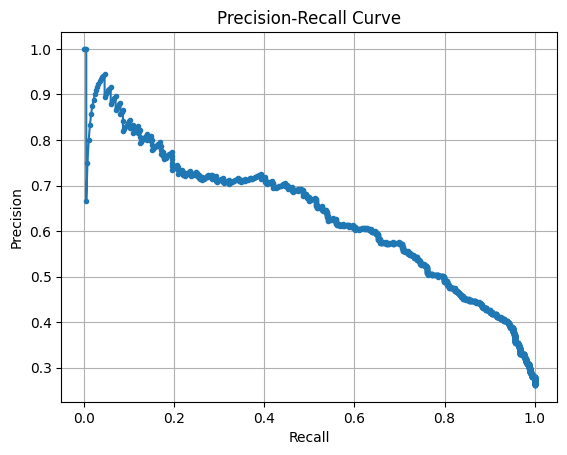

In [29]:
# Plot Precision-Recall Curve for ANN
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [30]:
# Display the results of all models
print("Model Evaluation Metrics:")
print(results)


Model Evaluation Metrics:
                 Model  Accuracy        F1  Precision    Recall
0  Logistic Regression  0.805259  0.592262   0.656766  0.539295
1   XGBoost Classifier  0.806681  0.587879   0.666667  0.525745


In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

# Load the dataset
dataset = pd.read_csv("Telco-Customer-Churn.csv")

# Data Cleaning
dataset.drop('customerID', axis='columns', inplace=True)
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')
dataset = dataset.dropna(subset=['TotalCharges'])

# Encode categorical variables
label_encoders = {}
for column in dataset.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset[column] = le.fit_transform(dataset[column])
    label_encoders[column] = le

# Feature Engineering: Create new feature 'TenureByMonthlyCharges'
dataset['TenureByMonthlyCharges'] = dataset['tenure'] * dataset['MonthlyCharges']

# Split the dataset into features and target variable
X = dataset.drop(columns='Churn')
y = dataset['Churn']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train RandomForestClassifier
clf_rf = RandomForestClassifier(random_state=0)
clf_rf.fit(X_train_scaled, y_train)
y_pred_rf = clf_rf.predict(X_test_scaled)

# Evaluate RandomForestClassifier
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)

# Train XGBoostClassifier with best parameters found earlier
best_params = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
clf_xgb = XGBClassifier(random_state=0, **best_params)
clf_xgb.fit(X_train_scaled, y_train)
y_pred_xgb = clf_xgb.predict(X_test_scaled)

# Evaluate XGBoostClassifier
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)

# Print the requested metrics
print(f" RandomForestClassifier  {acc_rf:.6f}  {f1_rf:.6f}   {prec_rf:.6f}  {rec_rf:.6f}")
print(f"1       XGBoostClassifier  {acc_xgb:.6f}  {f1_xgb:.6f}   {prec_xgb:.6f}  {rec_xgb:.6f}")


 RandomForestClassifier  0.793888  0.559271   0.636678  0.498645
1       XGBoostClassifier  0.797441  0.564885   0.646853  0.501355


/home/rnamala/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_2548687/1349746492.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': name, 'Accuracy': acc, 'F1': f1, 'Precision': prec, 'Recall': rec}, ignore_index=True)
/tmp/ipykernel_2548687/1349746492.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': name, 'Accuracy': acc, 'F1': f1, 'Precision': prec, 'Recall': rec}, ignore_index=True)
/tmp/ipykernel_2548687/1349746492.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pan

Model Evaluation Metrics:
                 Model  Accuracy        F1  Precision    Recall
0  Logistic Regression  0.804549  0.588939   0.656667  0.533875
4                  SVM  0.804549  0.560000   0.683594  0.474255
3              XGBoost  0.788913  0.557377   0.619205  0.506775
2        Random Forest  0.788202  0.545732   0.623693  0.485095
5                 k-NN  0.767591  0.547718   0.559322  0.536585
6          Naive Bayes  0.745558  0.603104   0.510319  0.737127
1        Decision Tree  0.733475  0.513619   0.492537  0.536585


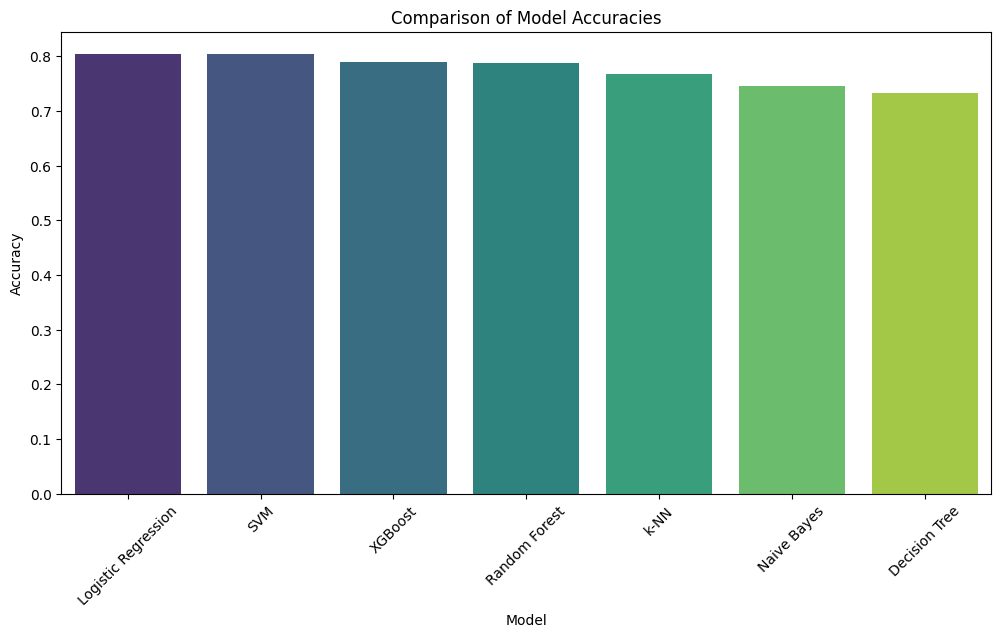

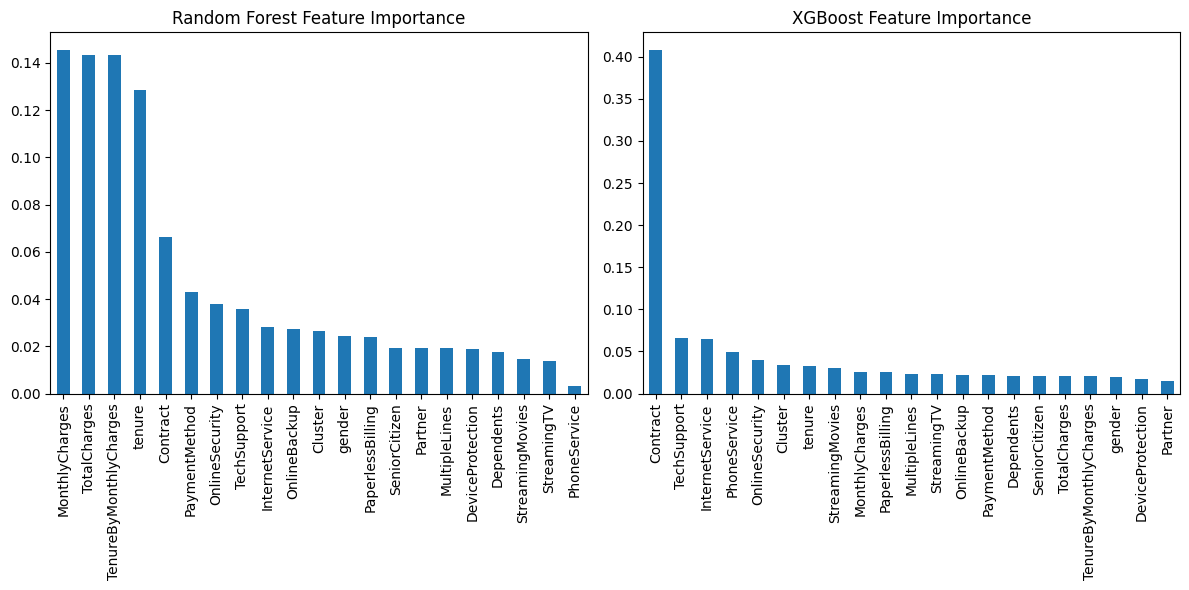

In [33]:

# Encode categorical variables
label_encoders = {}
for column in dataset.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset[column] = le.fit_transform(dataset[column])
    label_encoders[column] = le

# Feature Engineering: Create new feature 'TenureByMonthlyCharges'
dataset['TenureByMonthlyCharges'] = dataset['tenure'] * dataset['MonthlyCharges']

# Clustering with K-Means
from sklearn.cluster import KMeans

# Select features for clustering (excluding target variable and high cardinality features)
features_for_clustering = dataset.drop(columns=['Churn'])

# Standardize the features for clustering
scaler_clustering = StandardScaler()
features_for_clustering_scaled = scaler_clustering.fit_transform(features_for_clustering)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=0)  # Adjust number of clusters as needed
dataset['Cluster'] = kmeans.fit_predict(features_for_clustering_scaled)

# Split the dataset into features and target variable
X = dataset.drop(columns='Churn')
y = dataset['Churn']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# List of classifiers to evaluate
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=0),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "XGBoost": XGBClassifier(random_state=0),
    "SVM": SVC(random_state=0),
    "k-NN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# Initialize a dataframe to store the results
results = pd.DataFrame(columns=['Model', 'Accuracy', 'F1', 'Precision', 'Recall'])

# Evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    results = results.append({'Model': name, 'Accuracy': acc, 'F1': f1, 'Precision': prec, 'Recall': rec}, ignore_index=True)

# Sort the results by accuracy
results = results.sort_values(by='Accuracy', ascending=False)

# Print the evaluation results
print("Model Evaluation Metrics:")
print(results)

# Plot the evaluation results
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=results, palette='viridis')
plt.title('Comparison of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

# Feature Importance for Random Forest and XGBoost
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
importances_rf = pd.Series(classifiers['Random Forest'].feature_importances_, index=X.columns).sort_values(ascending=False)
importances_rf.plot(kind='bar', title='Random Forest Feature Importance')

plt.subplot(1, 2, 2)
importances_xgb = pd.Series(classifiers['XGBoost'].feature_importances_, index=X.columns).sort_values(ascending=False)
importances_xgb.plot(kind='bar', title='XGBoost Feature Importance')

plt.tight_layout()
plt.show()
